In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define transformation (Convert images to tensors & normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] for better training
])

# Download and load the MNIST dataset
batch_size = 64
dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Check dataset shape
images, labels = next(iter(dataloader))
print(f"Batch shape: {images.shape}")  # Expected: [64, 1, 28, 28]


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.35MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 54.3kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 241kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.64MB/s]

Batch shape: torch.Size([64, 1, 28, 28])


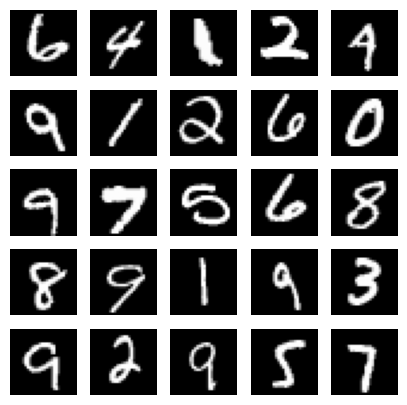

In [ ]:
# Function to display a batch of images
def show_images(images, num_images=25):
    images = images[:num_images]  # Select first 'num_images' images
    images = images.view(images.shape[0], 28, 28)  # Reshape for display
    images = images.detach().cpu().numpy()  # Convert to NumPy for plotting

    # Create a figure
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")  # Remove axes for better visibility
    plt.show()

# Get a batch of images
images, _ = next(iter(dataloader))
show_images(images)


In [ ]:
# Define the Generator class
class Generator(nn.Module):
    def __init__(self, noise_dim=100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),  # Fully connected layer
            nn.ReLU(),  # Activation function
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 28*28),  # Output layer (784 pixels)
            nn.Tanh()  # Normalize output to [-1, 1]
        )

    def forward(self, x):
        x = self.model(x)
        return x.view(-1, 1, 28, 28)  # Reshape to (batch_size, 1, 28, 28)

# Create Generator instance
noise_dim = 100  # Size of the random noise vector
generator = Generator(noise_dim)

# Print model summary
print(generator)


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [ ]:
# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),  # Input: 784 pixels (flattened image)
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),  # Output: Single value (real/fake)
            nn.Sigmoid()  # Sigmoid activation for probability
        )

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten image to vector
        return self.model(x)

# Create Discriminator instance
discriminator = Discriminator()

# Print model summary
print(discriminator)


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
# Define Binary Cross-Entropy Loss
loss_function = nn.BCELoss()

# Define optimizers for Generator & Discriminator
learning_rate = 0.0002
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Print confirmation
print("Loss function and optimizers defined successfully!")


Loss function and optimizers defined successfully!


In [ ]:
# Set training parameters
num_epochs = 50
batch_size = 128
noise_dim = 100  # Size of noise vector
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to GPU if available
generator.to(device)
discriminator.to(device)

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
])
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, transform=transform, download=True),
    batch_size=batch_size,
    shuffle=True
)

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # ---- Train Discriminator ----
        # Generate fake images
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Compute Discriminator loss
        real_loss = loss_function(discriminator(real_images), real_labels)
        fake_loss = loss_function(discriminator(fake_images.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        # Update Discriminator
        discriminator_optimizer.zero_grad()
        d_loss.backward()
        discriminator_optimizer.step()

        # ---- Train Generator ----
        # Generate fake images
        noise = torch.randn(batch_size, noise_dim, device=device)
        fake_images = generator(noise)

        # Compute Generator loss (want D to classify fake as real)
        g_loss = loss_function(discriminator(fake_images), real_labels)

        # Update Generator
        generator_optimizer.zero_grad()
        g_loss.backward()
        generator_optimizer.step()

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]  D Loss: {d_loss.item():.4f}  G Loss: {g_loss.item():.4f}")

print("Training Complete!")


Epoch [1/50]  D Loss: 0.6403  G Loss: 2.0669
Epoch [2/50]  D Loss: 0.6924  G Loss: 1.3931
Epoch [3/50]  D Loss: 0.7403  G Loss: 1.4653
Epoch [4/50]  D Loss: 0.6792  G Loss: 1.7108
Epoch [5/50]  D Loss: 0.6786  G Loss: 1.5510
Epoch [6/50]  D Loss: 0.5406  G Loss: 1.8532
Epoch [7/50]  D Loss: 0.8077  G Loss: 1.6618
Epoch [8/50]  D Loss: 0.7251  G Loss: 1.7910
Epoch [9/50]  D Loss: 0.6555  G Loss: 1.7605
Epoch [10/50]  D Loss: 0.7004  G Loss: 1.6066
Epoch [11/50]  D Loss: 0.7541  G Loss: 1.6538
Epoch [12/50]  D Loss: 0.6081  G Loss: 1.8322
Epoch [13/50]  D Loss: 0.7834  G Loss: 1.5514
Epoch [14/50]  D Loss: 0.7682  G Loss: 1.6160
Epoch [15/50]  D Loss: 0.5980  G Loss: 1.6706
Epoch [16/50]  D Loss: 0.7142  G Loss: 1.7540
Epoch [17/50]  D Loss: 0.7746  G Loss: 1.9127
Epoch [18/50]  D Loss: 0.7029  G Loss: 1.3539
Epoch [19/50]  D Loss: 0.8079  G Loss: 1.7105
Epoch [20/50]  D Loss: 0.7402  G Loss: 1.7988
Epoch [21/50]  D Loss: 0.7163  G Loss: 1.7754
Epoch [22/50]  D Loss: 0.5838  G Loss: 1.83

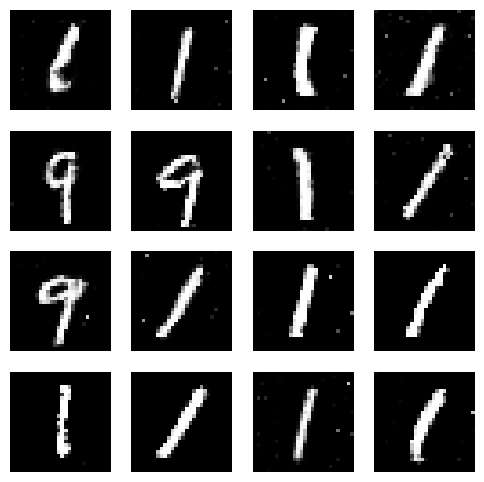

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to generate and visualize images
def generate_and_visualize(generator, num_images=16):
    generator.eval()  # Set to evaluation mode
    noise_dim = 100
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Generate fake images
    noise = torch.randn(num_images, noise_dim, device=device)
    fake_images = generator(noise).cpu().detach()

    # Reshape images and scale back to [0,1]
    fake_images = fake_images.view(num_images, 28, 28).numpy()
    fake_images = (fake_images + 1) / 2  # Normalize from [-1,1] to [0,1]

    # Plot images
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(fake_images[i], cmap="gray")
        ax.axis("off")
    plt.show()

# Generate and visualize images after training
generate_and_visualize(generator)


In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=7, stride=1, padding=0, bias=False),  # (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 14, 14)
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 28, 28)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1, bias=False),  # (1, 28, 28)
            nn.Tanh()  # Output in range [-1,1]
        )

    def forward(self, z):
        return self.model(z)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),  # (64, 14, 14)
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # (128, 7, 7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=False),  # (256, 7, 7)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, kernel_size=7, stride=1, padding=0, bias=False),  # (1, 1, 1)
            nn.Sigmoid()  # Probability of real vs fake
        )

    def forward(self, img):
        return self.model(img)


In [ ]:
# Initialize models
latent_dim = 100
generator = Generator(latent_dim)
discriminator = Discriminator()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
num_epochs = 20
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, 1, 1)
        fake_labels = torch.zeros(batch_size, 1, 1, 1)

        # Train Discriminator
        optimizerD.zero_grad()
        real_outputs = discriminator(real_images)
        loss_real = criterion(real_outputs, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1)  # Random noise
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        loss_fake = criterion(fake_outputs, fake_labels)

        lossD = loss_real + loss_fake
        lossD.backward()
        optimizerD.step()

        # Train Generator
        optimizerG.zero_grad()
        fake_outputs = discriminator(fake_images)
        lossG = criterion(fake_outputs, real_labels)  # Try to fool Discriminator
        lossG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(dataloader)}], D Loss: {lossD.item()}, G Loss: {lossG.item()}")


Epoch [0/20], Step [0/938], D Loss: 1.3230125904083252, G Loss: 1.1631126403808594
Epoch [0/20], Step [100/938], D Loss: 0.0010990158189088106, G Loss: 7.628684997558594
Epoch [0/20], Step [200/938], D Loss: 0.0012680377112701535, G Loss: 7.361220359802246
Epoch [0/20], Step [300/938], D Loss: 0.00021254870807752013, G Loss: 9.111315727233887
Epoch [0/20], Step [400/938], D Loss: 0.00015874943346716464, G Loss: 9.512048721313477
Epoch [0/20], Step [500/938], D Loss: 0.00048258702736347914, G Loss: 8.991901397705078
Epoch [0/20], Step [600/938], D Loss: 8.743259240873158e-05, G Loss: 10.015542984008789
Epoch [0/20], Step [700/938], D Loss: 5.499056715052575e-05, G Loss: 10.203367233276367
Epoch [0/20], Step [800/938], D Loss: 3.420656139496714e-05, G Loss: 10.82568645477295
Epoch [0/20], Step [900/938], D Loss: 3.791660856222734e-05, G Loss: 10.58017635345459
Epoch [1/20], Step [0/938], D Loss: 5.810957009089179e-05, G Loss: 10.627908706665039
Epoch [1/20], Step [100/938], D Loss: 0.877

In [ ]:
import matplotlib.pyplot as plt

# Generate fake images
z = torch.randn(16, latent_dim, 1, 1)  # Random noise
fake_images = generator(z).detach().cpu()

# Convert to NumPy and Rescale to [0,1] for visualization
fake_images = fake_images.numpy().transpose(0, 2, 3, 1)
fake_images = (fake_images + 1) / 2.0  # Convert from [-1,1] to [0,1]

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i, :, :, 0], cmap="gray")
    ax.axis("off")

plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Generate fake images
z = torch.randn(16, latent_dim, 1, 1)  # Random noise
fake_images = generator(z).detach().cpu()

# Convert to NumPy and Rescale to [0,1] for visualization
fake_images = fake_images.numpy().transpose(0, 2, 3, 1)
fake_images = (fake_images + 1) / 2.0  # Convert from [-1,1] to [0,1]

# Plot the generated images
fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i, :, :, 0], cmap="gray")
    ax.axis("off")

plt.show()
